## Exemple 4
### Població d'aus i caiguda de pressió

[Coleman 2018](#bib_Coleman)

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import Math, display
import sympy as sp
from sympy.physics.units.systems import SI
from sympy.physics.units import meter, second, liter, hour, degree, convert_to
from sympy import sin, cos, pi, Abs

sp.init_printing()

def show(*args):
    out = ""
    for arg in args:
        if isinstance(arg, (sp.Expr, sp.Eq)):
            arg = sp.latex(arg)
        else:
            arg = str(arg)
        out += arg
    display(Math(out))
    
qq = "\quad "

### Població d'aus
- Tenim una població d'aus a un parc natural i volem saber com evolucionarà. Actualment contem amb 5000 exemplars.

- Fem les següents assumcions

    - La taxa de naixements depèn de la quantitat de menjar disponible a la zona.
    
    - La quantitat de menjar depen del cicle de plutjes de El Niño que te un període de 4 anys.
    
    - Hi ha un efecte migratòri que suposa una taxa de migració neta de 100 exemplars anuals.

In [2]:
# Població d'aus
from sympy.abc import t, a, b, m, T, C, D
T0, Tn = sp.symbols('T_0 T_n')
P = sp.Function('P', real=True)

dP = sp.diff(P(t), t)
R = a + b * sp.sin(2 * sp.pi * (t - T0) / Tn) 
M = m

eq = sp.Eq(dP, R * P(t) - m)
Pt = sp.dsolve(eq, P(t))
Pt

       ⎛       ⌠                                 ⎞                                
       ⎜       ⎮                ⎛2⋅π⋅(T₀ - t)⎞   ⎟            ⎛2⋅π⋅(T₀ - t)⎞      
       ⎜       ⎮        Tₙ⋅b⋅cos⎜────────────⎟   ⎟    Tₙ⋅b⋅cos⎜────────────⎟      
       ⎜       ⎮                ⎝     Tₙ     ⎠   ⎟            ⎝     Tₙ     ⎠      
       ⎜       ⎮        ──────────────────────   ⎟  - ────────────────────── + a⋅t
       ⎜       ⎮  -a⋅t           2⋅π             ⎟             2⋅π                
P(t) = ⎜C₁ - m⋅⎮ ℯ    ⋅ℯ                       dt⎟⋅ℯ                              
       ⎝       ⌡                                 ⎠                                

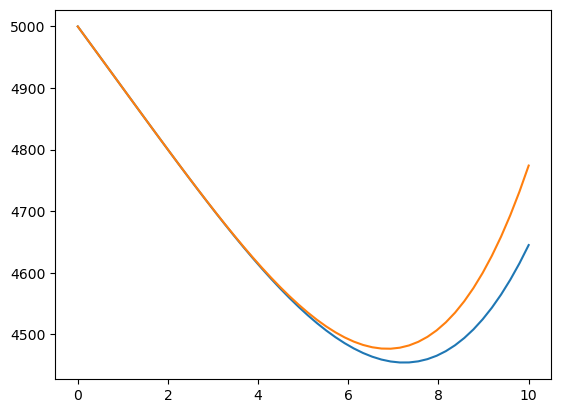

In [3]:
# Aproximacions 
cons = {'C1': C}
valors = {a: 0.00001, b: -0.0001, T0: 0, Tn: 4, m: 100, C: 5000}

Pt5 = sp.dsolve(eq, P(t), hint='1st_power_series', n=5)
fPt5 = sp.lambdify('t', Pt5.rhs.subs(cons).subs(valors).removeO())

Pt6 = sp.dsolve(eq, P(t), hint='1st_power_series', n=6)
fPt6 = sp.lambdify('t', Pt6.rhs.subs(cons).subs(valors).removeO())

x = np.linspace(0, 10)
p6 = fPt6(x)
p5 = fPt5(x)
l = plt.plot(x, p6, x, p5)

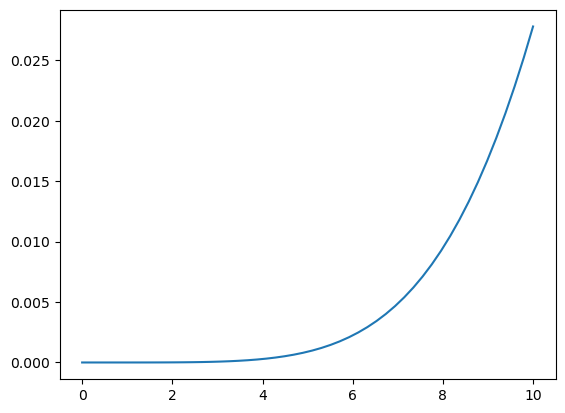

In [4]:
x = np.linspace(0, 10)
l = plt.plot(x, np.abs((p6 - p5)/p6))

## Caiguda de pressió
- Volem fer predir la perduda de pressió d'un fluït quan passa a través d'una canonada amb certa rugositat
- Necessitem una precisió del 5% amb un 99% de nivell de confiança
- Prenem mesures de pressió i flux per validar el nostre model
    - El manòmetre té una resolució de 10 Pa
    - El flowmeter té una resolució de 10 ml/s
    - Els paràmetres tabulats els coneixem amb una precisió d' 1/1000
- Quin és l'error del model?

### Paràmetres
- Densitat $\rho = 1 \,g/ml$
- Rugositat $\epsilon = \,1 cm$
- Diàmetre $d = \,15cm$
- Viscositat dinàmica $\mu = 1.2 \,mPa \cdot s$
- Llargària del tub $L = 1000 m$

In [5]:
# Model
from sympy.abc import rho, epsilon, mu, Q, L, d, f
Re = sp.symbols('Re')

DP = f * 8 * rho * Q**2 * L / (sp.pi**2 * d**5)
show('\Delta P = ', DP)

f = 1 / (-1.8 * sp.log(6.9 / Re + (epsilon/d/3.7)**1.11))**2
show('f = ', f)

Re = 4 * Q * rho / (sp.pi * mu * d)
show('Re =', Re)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Index(['Flow (l/s)', '\Delta P (Pa)'], dtype='object')


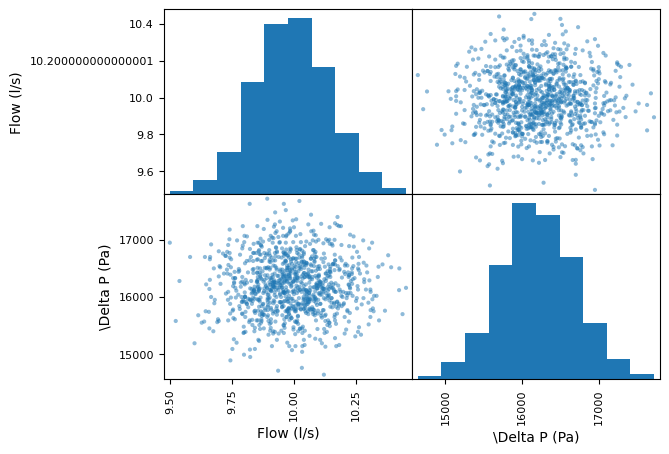

In [6]:
# Dades
data = pd.read_csv("../data/dp_data.csv")
print(data.columns)

l = pd.plotting.scatter_matrix(data[data.columns])

In [7]:
print(data.mean(), '\n', data.std())

Flow (l/s)           9.992599
\Delta P (Pa)    16201.240000
dtype: float64 
 Flow (l/s)         0.151722
\Delta P (Pa)    491.664720
dtype: float64


In [8]:
# Simulació
valors = {rho: 1000, epsilon: 0.01, mu: 1.2E-3, L: 1000, d: 0.15}

f = 1 / (-1.8 * sp.log(6.9 / Re + (epsilon/d/3.7)**1.11))**2
DP = f * 8 * rho * Q**2 * L / (sp.pi**2 * d**5)
show('\Delta P = ', DP.subs(valors))

<IPython.core.display.Math object>

16617.507221274012 503.4327964433551


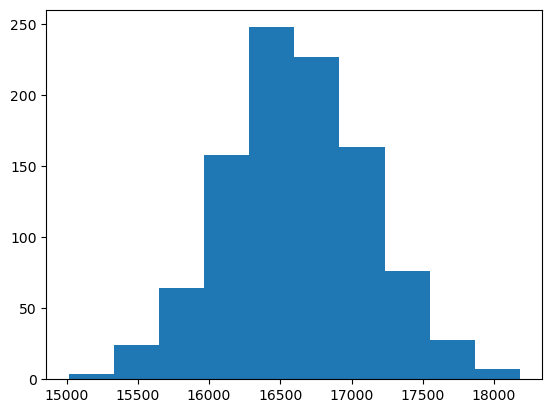

In [9]:
fDP = sp.lambdify(Q, DP.subs(valors))
q = data['Flow (l/s)'] / 1000
dp = fDP(q)

l = plt.hist(dp)
print(np.mean(dp), np.std(dp))

416.2672212740126


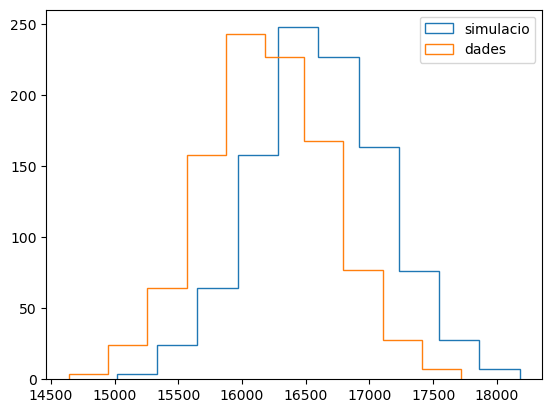

In [10]:
# Discrepància
S = np.mean(dp)
D = data.mean()['\Delta P (Pa)']
E = S - D
print(E)

l = plt.hist(dp, histtype='step')
l = plt.hist(data['\Delta P (Pa)'], histtype='step')
l = plt.legend(['simulacio', 'dades'])

### Incerteses

$$E = S - D = f \frac{8 L Q^2 \rho}{\pi^2 d^5} - \Delta P$$

$$u_v = \sqrt{u_n^2 + u_p^2 + u_D^2}$$

- Desestimant l'incertesa numèrica

$$
\begin{align}
u_v^2 & = u_p^2 + u_D^2 \\
u_D   & = \sigma(\Delta P) \\
u_p   & = \sum{\theta i^2  u_i^2}\\
      & = \sum{\theta i^2  x_i^2  ur_i^2}\\
\end{align}
$$

In [11]:
Re = 4 * Q * rho / (sp.pi * mu * d)
f = 1 / (-1.8 * sp.log(6.9 / Re + (epsilon/d/3.7)**1.11))**2
DP = f * 8 * rho * Q**2 * L / (sp.pi**2 * d**5)
DP

                                  2                
              2.46913580246914⋅L⋅Q ⋅ρ              
───────────────────────────────────────────────────
          ⎛                     1.11              ⎞
 2  5    2⎜                  ⎛ε⎞       1.725⋅π⋅d⋅μ⎟
π ⋅d ⋅log ⎜0.234043231705236⋅⎜─⎟     + ───────────⎟
          ⎝                  ⎝d⎠           Q⋅ρ    ⎠

In [12]:
# Derivades parcials
mesures = {Q: q.mean()}
SL = sp.diff(DP, L).subs(valors).subs(mesures).n()
SQ = sp.diff(DP, Q).subs(valors).subs(mesures).n()
Sr = sp.diff(DP, rho).subs(valors).subs(mesures).n()
Sd = sp.diff(DP, d).subs(valors).subs(mesures).n()
Se = sp.diff(DP, epsilon).subs(valors).subs(mesures).n()
Sm = sp.diff(DP, mu).subs(valors).subs(mesures).n()
show(SL, qq,
     SQ, qq,
     Sr, qq,
     Sd, qq,
     Se, qq,
     Sm, qq,
)

<IPython.core.display.Math object>

In [13]:
# Incertesa dels paràmetres al quadrat
up2 = np.sum(np.power([
    SL * valors[L] * 0.001,
    SQ * q.std(),
    Sr * valors[rho] * 0.001,
    Sd * valors[d] * 0.001,
    Se * valors[epsilon] * 0.001,
    Sm * valors[mu] * 0.001,
], 2))

In [14]:
# Incertesa de l'estimació de la discrepància
uD = data.std()['\Delta P (Pa)']

uV = np.sqrt(float(uD**2 + up2))
uV

710.1021512805262

In [15]:
# Discrepància
show("E = %0.f \pm %0.f Pa" % (E, uV))

<IPython.core.display.Math object>

In [16]:
# Error relatiu del model
ur = E/S
ur

0.02504991968597434

In [17]:
# Nivell de confiança per un error del 5%
t = 0.05 / ur
l, h = stats.t.cdf([-t, t], 1000)
CL = h - l
CL

0.9537968114100377

# Referències

- <a id='bib_Edwards'></a> Edwards, D., **2001**. *Guide to mathematical modelling*. Palgrave, Basingstoke.
- <a id='bib_Coleman'></a> Coleman, Hugh W. & Steele, W. Glenn, **2018**. *Experimentation, validation, and uncertainty analysis for engineers*. Wiley.

Copyright (C) 2022 Gabriel Jover Mañas

    Permission is granted to copy, distribute and/or modify this document
    under the terms of the GNU Free Documentation License, Version 1.3
    or any later version published by the Free Software Foundation;
    with no Invariant Sections, no Front-Cover Texts, and no Back-Cover Texts.
    A copy of the license is included in the section entitled "GNU
    Free Documentation License".

![GFDL][GFDL]

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

![GPL3][GPL3]

[GFDL]: https://www.gnu.org/graphics/gfdl-logo.svg
[GPL3]: https://www.gnu.org/graphics/gplv3-or-later.svg